# Hyperbolic Support Vector Classifier
`Drew Wilimitis`

In this notebook, I attempt to implement another foundational supervised learning algorithm in hyperbolic space to continue exploring how hyperbolic embeddings can be integrated with downstream machine learning tasks in order to fully exploit the representational capacity of hyperbolic geometry. <br>
<br>
I follow the approach recently outlined in "Large-margin classification in hyperbolic space". Cho, H., Demeo, B., Peng, J., Berger, B. CoRR abs/1806.00437 (2018)

The original authors released a MATLAB implementation (https://github.com/hhcho/hyplinear) of hyperbolic support vector classifiers, which was then first implemented in python available through the excellent open-source repository - https://github.com/plumdeq/hsvm. <br>

## Algorithm Outline

Given data in the Poincare disk $\mathcal{B}^{d}$, consider supervised learning setting where we have training data instances with features $x^{j}$ and labels $y^{j}$: <br>
$$
\left\{\left(x^{(j)}, y^{(j)}\right)\right\}_{j=1}^{m}
$$ <br>
<br>
The basic steps in Hyperbolic SVM are: <br>
1. **Initialization step**: initialize weight vector $w$ that defines decision boundary <br>
2. **Optimization problem**: formulate standard euclidean max-margin optimization in hyperbolic space <br>
3. **Projected gradient descent**: iteratively solve for optimal $w$ via projected gradient descent in the hyperboloid model <br>
4. **Predict on new data samples**: use transitions between poincaré disk and hyperboloid models with decision boundary classification rules to perform supervised learning in hyperbolic space<br>

### Hyperbolic max-margin optimization  

$$
\begin{array}{c}{\text { minimize }_{w \in \mathbb{R}^{n+1}}-\frac{1}{2} w * w+C \sum_{j=1}^{m} \max \left(0, \sinh ^{-1}(1)-\sinh ^{-1}\left(y^{(j)}\left(w * x^{(j)}\right)\right)\right)} \\ {\text { subject to } w * w<0}\end{array}
$$

Projected gradient descent: project $y$ onto set $X$:<br>
$$
\Pi_{X}(y)=\underset{x \in X}{\operatorname{argmin}} \frac{1}{2}\|x-y\|_{2}^{2}
$$

## Load libraries and helper functions

In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit, KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_recall_curve, accuracy_score, precision_score, recall_score
from sklearn.metrics import auc, confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import time
import sys
import os

# import modules within repository
my_path = 'C:\\Users\\dreww\\Desktop\\hyperbolic-learning\\utils' # path to utils folder
#my_path = 'C:\\Users\\1394852\\Documents\\GitHub\\hyperbolic-learning\\utils'
sys.path.append(my_path)
from utils import *
from hsvm import *
from datasets import *
from embed import *
from platt import *

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

### Multiclass decision boundaries and Platt probability scaling

Use One vs. Rest (OVR) multiclass method - train a separate binary classifier for each of the $k$ classes and provide separate prediction scores for each class compared to the rest. Prediction scores are decision function values given by minkowski inner product $w_i * X$, for a given classifiers trained weight vector $w_i$ and the observations $X$. <br>
<br>
We then use the Platt scaling method to output probabilities - we find the coefficients A and B that provide the posterior probability $P(y=1|x) = 1/(1+exp(A*f(x)+B))$, where $f(x)$ is a decision function value (minkowski inner product) for a given point $x$ in the hyperboloid. 

## Ex. 1) Synthetically generated gaussian mixture data

The authors provide data generated from hyperbolic Gaussian distributions, where each dataset contains 400 sample observations with labels indicating which of the 4 different gaussian clusters they belong to. I attempt to provide visualizations of hyperbolic decision boundaries and begin to evaluate hyperbolic svm classification performance.

In [7]:
# read files from local path
import os
import scipy.io as sio
path = 'C:/Users/dreww/Desktop/hyplinear-master/data/gaussian'
mat_files = []
for f in os.listdir(path):
    mat_files.append(path + '/' + f)

In [3]:
# visualize poincare decision boundaries for multiclass gaussian data
def plot_gaussian(X, labels):
    # initalize plot
    ax = plt.gca()
    colors = ['b', 'r', 'g', 'y']
    
    # fit multiclass hsvm and get prediction accuracy
    hsvm_clf = LinearHSVM(early_stopping=1, C=10, num_epochs=20, lr=0.001, verbose=False, multiclass=True)
    hsvm_clf.fit(poincare_pts_to_hyperboloid(X, metric='minkowski'), labels)
    y_pred = hsvm_clf.predict(poincare_pts_to_hyperboloid(X, metric='minkowski'))
    matrix = confusion_matrix(labels, y_pred)
    acc_scores = matrix.diagonal()/matrix.sum(axis=1)
          
    # plot pts x that make up decision boundary in poincare disk
    w = hsvm_clf.coef_
    n_classes = len(hsvm_clf.class_labels_)
    # select random uniform sample over poincare disk
    L2 = poincare_pts_to_hyperboloid(-2*np.random.rand(1000000, 2)+1, metric='minkowski')
    for i in range(n_classes):
        # use approximated definition of hyperbolic decision boundary, i.e. the set {x: minkowski_dot(x, w) = 0}
        inter = np.array([np.abs(minkowski_dot(x, w[i])) for x in L2]) < 1e-2
        dec_bound = L2[inter]
        ball_dec = hyperboloid_pts_to_poincare(dec_bound, metric='minkowski')
        ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
        plt.scatter(-ball_dec[:, 0], -ball_dec[:, 1], s=30, color=colors[i], marker='.')
        
    # plot observations with true class labels (randomly generated data from gaussian clusters)
    circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.7)
    ax.add_patch(circ)
    for i in range(n_classes):
        ax.scatter(X[(labels==i),0], X[(labels==i),1], c=colors[i], 
                    label = 'acc: ' + str(np.round(acc_scores[i], 3)),
                    alpha=0.5, edgecolors='black', linewidths=1, s=40)
    
    # plot legend and display
    ax.legend(loc='upper right', fontsize=10, shadow=True, edgecolor='black')
    plt.xlim([-1.1,1.2])
    plt.ylim([-1.1,1.2])
    plt.title('Overall Classification Accuracy: {}'.format(accuracy_score(labels, y_pred)), size=10);
    return ball_dec

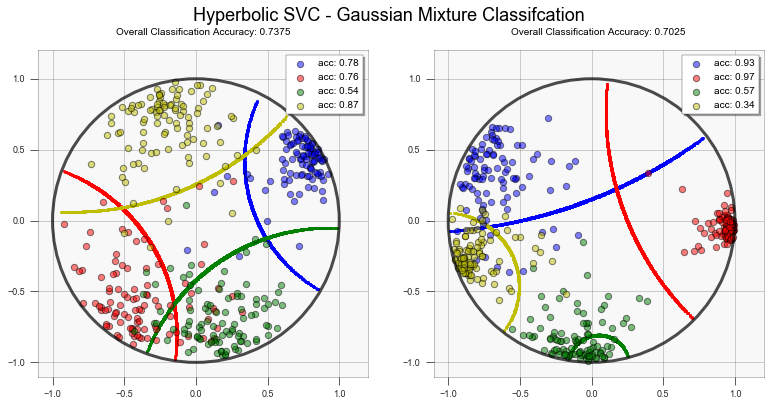

In [5]:
from qbstyles import mpl_style
mpl_style(dark=False)

# plot hyperbolic decision boundaries and classification accuracy
fig = plt.figure(figsize=(13,6))
for i, file_num in enumerate([27, 28]):
    ax = fig.add_subplot(1,2,i+1)
    X, y = load_mat_file(mat_files[file_num])
    plot_gaussian(X, y-1);
plt.suptitle('Hyperbolic SVC - Gaussian Mixture Classifcation', size=18)
plt.savefig('hsvm_decision_boundaries.png')
plt.show();

### Model Parameters and Training Metrics

In [37]:
def training_metrics(X_train, y_train, X_test=None, y_test=None, num_trials=20):
    # if no test sets given, evaluate on train data
    if X_test == None or y_test == None:
        X_test = X_train
        y_test = y_train
    # get accuracy for different training epochs
    epoch_scores = []
    for i in range(num_trials):
        hsvm_clf = LinearHSVM(early_stopping=1, C=5, num_epochs=i, lr=0.001, verbose=False, multiclass=True)
        hsvm_clf.fit(poincare_pts_to_hyperboloid(X_train, metric='minkowski'), y_train)
        y_pred = hsvm_clf.predict(poincare_pts_to_hyperboloid(X_test, metric='minkowski'))
        epoch_scores.append(accuracy_score(y_test, y_pred))
    # test accuracy for different C values
    C_scores = []
    C_range = [0.1, 0.25, 0.5, 1, 2.5, 5, 7.5, 10, 25]
    for param_c in C_range:
        hsvm_clf = LinearHSVM(early_stopping=1, C=param_c, num_epochs=20, lr=0.001, verbose=False, multiclass=True)
        hsvm_clf.fit(poincare_pts_to_hyperboloid(X_train, metric='minkowski'), y_train)
        y_pred = hsvm_clf.predict(poincare_pts_to_hyperboloid(X_test, metric='minkowski'))
        C_scores.append(accuracy_score(y_test, y_pred))
    # test batch size effects
    batch_scores = []
    for batch_size in np.arange(5, 50, 5):
        hsvm_clf = LinearHSVM(early_stopping=1, C=5, num_epochs=20, lr=0.001, verbose=False,
                              multiclass=True, batch_size=batch_size)
        hsvm_clf.fit(poincare_pts_to_hyperboloid(X_train, metric='minkowski'), y_train)
        y_pred = hsvm_clf.predict(poincare_pts_to_hyperboloid(X_test, metric='minkowski'))
        batch_scores.append(accuracy_score(y_test, y_pred))
    # test learning rate parameter vals
    lr_scores = []
    for eta in [1/10**x for x in np.arange(0, 8)]:
        hsvm_clf = LinearHSVM(early_stopping=1, C=5, num_epochs=20, lr=eta, verbose=False, multiclass=True)
        hsvm_clf.fit(poincare_pts_to_hyperboloid(X_train, metric='minkowski'), y_train)
        y_pred = hsvm_clf.predict(poincare_pts_to_hyperboloid(X_test, metric='minkowski'))
        lr_scores.append(accuracy_score(y_test, y_pred))
    score_dict = dict(zip(['epochs', 'C', 'batch_size', 'lr'],
                          [epoch_scores, C_scores, batch_scores, lr_scores]))
    return score_dict

In [265]:
# keep dict with parameter grid tested
params = {'epochs': np.array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
         'C': [0.1, 0.25, 0.5, 1, 2.5, 5, 7.5, 10, 25],
         'batch_size': np.array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
         'lr': [1.0, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07]}

# run training metrics for n_rounds and get overall metrics
n_rounds = 10
agg_scores = {}
for k,v in params.items():
    agg_scores[k] = np.zeros((n_rounds, len(v)))

for i, file_num in enumerate(np.random.permutation(100)[:n_rounds]):
    X, y = get_gaussian_data(mat_files[file_num])
    labels = y-1
    scores = training_metrics(X, labels)
    for k, v in scores.items():
        agg_scores[k][i] = v

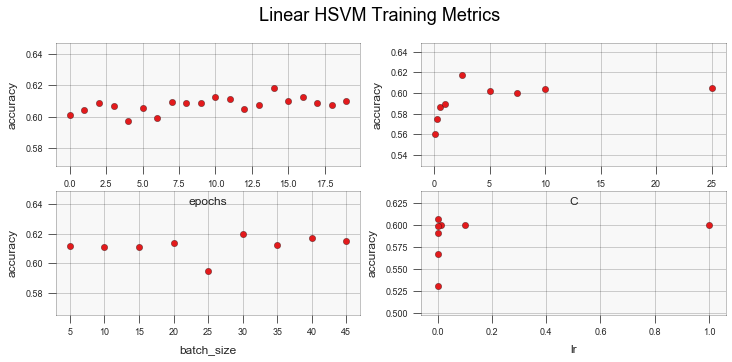

In [266]:
from qbstyles import mpl_style
mpl_style(dark=False)
fig = plt.figure(figsize=(12,5))
#plt.style.use('bmh')
plt.suptitle('Linear HSVM Training Metrics', size=18)
for i, param in enumerate(['epochs', 'C', 'batch_size', 'lr']):
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(params[param], np.sum(agg_scores[param], axis= 0) / n_rounds, s=40, edgecolor='black')
    plt.ylabel('accuracy')
    plt.xlabel(param)
plt.show();

### Cross Validation Results

I use the same two-fold cross validation approach, grouping over sets of five trials and looking at the average performance results. I also use the macro-averaged AUPR in order to compare the results with those reported in **[1]** <br>
<br>
We first need to find the AUPR for each of the separate, one vs. rest classifiers and then take the average AUPR scores over all the classes. For each of the 100 datasets, we have to run five independent trials of two-fold cross validation.

In [35]:
from sklearn.metrics import precision_recall_curve, classification_report, roc_auc_score, auc
from sklearn.model_selection import KFold, StratifiedKFold
from numpy import interp

# computes Area under precision-recall curve
def aucpr(y_true, y_scores):
    recall_array = np.linspace(0, 1, 100)
    p, r, thresh = precision_recall_curve(y_true, y_scores)
    p, r, thresh = p[::-1], r[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, r, p)
    threshold_array = interp(recall_array, r, thresh)
    auc_pr = auc(recall_array, precision_array)
    return auc_pr

# cross-validation to be run with given One Vs Rest classifiers
def cross_val(X, y, k=2, n_trials=5):
    cv_scores = []
    for i in range(n_trials):
        #kf = KFold(n_splits=k, shuffle=True)
        skf = StratifiedKFold(n_splits=k, shuffle=True)
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            hsvm_clf = LinearHSVM(early_stopping=1, C=10, num_epochs=10, lr=0.01, verbose=False)
            hsvm_clf.fit(poincare_pts_to_hyperboloid(X_train, metric='minkowski'), y_train)
            y_pred_prob = hsvm_clf.predict_proba(poincare_pts_to_hyperboloid(X_test, metric='minkowski'))
            cv_scores.append(aucpr(y_test, y_pred_prob))
    return cv_scores

def macro_avg_scores(X, y, num_rounds = 5, k=2, cv_trials=5):
    y_binary = label_binarize(y, classes = np.unique(y))
    n_classes = len(np.unique(y))
    eval_scores = np.zeros((num_rounds, n_classes))
    for i in range(num_rounds):
        for j in range(n_classes):
            eval_scores[i, j] = np.mean(cross_val(X, y_binary[:, j], k=k, n_trials=cv_trials))
    return np.mean(eval_scores, axis=1)

# run cross-val across all datasets for each binary classifier
def evaluate_hsvm(n_datasets):
    n_classes = 4
    eval_scores = np.zeros((n_datasets, n_classes))
    for i in range(n_datasets):
        X, y = get_gaussian_data(mat_files[i])
        y = y-1
        y_binary = label_binarize(y, classes = np.unique(y))
        for j in range(n_classes):
            eval_scores[i, j] = np.mean(cross_val(X, y_binary[:, j], k=2, n_trials=5))
    return eval_scores

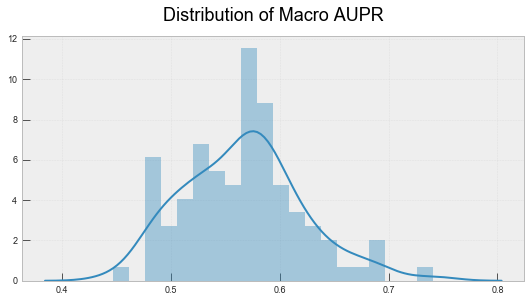

In [268]:
# aggregate final results and plot Macro AUPR
final_scores = evaluate_hsvm(100)

plt.figure(figsize=(9,4.5))
#from qbstyles import mpl_style
#mpl_style(dark=False)
plt.style.use('bmh')
sns.distplot(np.mean(final_scores, axis=1), bins=20);
plt.title('Distribution of Macro AUPR', size=18);
plt.show();

## Ex 2.) Real world social networks

We now test hyperbolic SVM on a few well-known, benchmark social networks in order to compare hyperbolic classifiers performance. <br>

Here I just load pre-trained, hyperbolic embeddings of these networks and then attempt classification with hyperbolic svm.

###  Zachary karate club network

Undirected graph connecting members (nodes) of a karate club <br>
34 nodes, 78 edges, split into 2 different classes

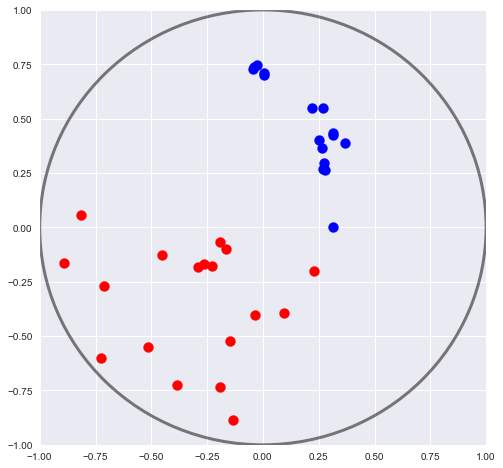

In [8]:
# true class labels (from An Information Flow Model for Conflict and Fission in Small Groups (1977))
karate_df = pd.read_csv('../hyperbolic_kmeans/models/karate_vectors', sep=' ')
true_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
                               0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
karate_df.columns = ['x', 'y']
karate_df['label'] = true_labels[karate_df.index.values-1]
karate_df.sort_index(inplace=True)

# load embedding vectors
#karate_df = pd.read_csv('karate_labels')
karate_df.head()
plt.figure(figsize=(8,8))
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.scatter(karate_df.loc[karate_df.label == 0, 'x'], karate_df.loc[karate_df.label == 0, 'y'], color='blue', s=100);
plt.scatter(karate_df.loc[karate_df.label == 1, 'x'], karate_df.loc[karate_df.label == 1, 'y'], color='red', s=100);

In [9]:
X = np.array(karate_df[['x', 'y']])
y = karate_df['label'].values

# evaluate predictions
hsvm_clf = LinearHSVM(early_stopping=1, C=5, num_epochs=20, lr=0.01, verbose=False)
karate_f1 = evaluate_model(hsvm_clf, X, y, report=True, classifier='hsvm')
karate_aupr = np.mean(cross_val(X, y))
print('CV avg macro f1-score:', np.mean(karate_f1))
print('Macro AUPR: ', np.mean(cross_val(X, y)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         2

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7

CV avg macro f1-score: 1.0
Macro AUPR:  1.0


### NCAA Football Teams

In [10]:
import networkx as nx

# load pre-trained embedding coordinates
emb = load_embeddings('../hyperbolic_kmeans/models/football_vectors')
emb_data = np.array(emb.iloc[:, 1:3])
emb_data.shape

# get team name labels with embedding coords
G = nx.read_gml('../hyperbolic_kmeans/football/football.gml', label='id')
teams = []
for i in range(emb.shape[0]):
    teams.append(G.node[i]['label'])

ncaa_labels = []
for i in range(emb.shape[0]):
    ncaa_labels.append(G.node[i]['value'])

(115, 2)

In [11]:
# true class labels 
y = np.array(ncaa_labels)
X = emb_data

# evaluate predictions
hsvm_clf = LinearHSVM(early_stopping=1, C=10, num_epochs=20, lr=0.01, verbose=False, multiclass=True)
football_f1 = evaluate_model(hsvm_clf, X, y, report=True, classifier='hsvm')
football_aupr = np.mean(macro_avg_scores(X, y, k=2, num_rounds=5, cv_trials=2))
print('CV avg macro f1-score:', np.mean(football_f1))
print('Macro AUPR: ', macro_avg_scores(X, y, k=2, num_rounds=5, cv_trials=2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         3
           4       0.38      1.00      0.55         3
           6       0.75      1.00      0.86         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         4
           9       0.50      0.50      0.50         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         3

    accuracy                           0.30        23
   macro avg       0.15      0.23      0.17        23
weighted avg       0.19      0.30      0.23        23

CV avg macro f1-score: 0.18655833055833054
Macro AUPR:  [0.30931406 0.30372018 0.32175356 0.31906192 0.32520472]


## Polbooks

441 undirected edges, 105 nodes, 3 classes 

In [38]:
# load pre-trained embedding coordinates
emb = load_embeddings('../hyperbolic_kmeans/models/polbooks_vectors')
emb_data = np.array(emb.iloc[:, 1:3])
emb_data.shape

# get true class labels
G = nx.read_gml('../hyperbolic_kmeans/polbooks/polbooks.gml.txt', label='id')
labels = []
for i in range(emb.shape[0]):
    labels.append(G.node[i]['value'])
labels = np.array(labels)
class_map = {'n': 0, 'c': 1, 'l': 2}
polbook_labels = np.array([class_map[x] for x in labels])

(105, 2)

In [40]:
# true class labels 
y = polbook_labels
X = emb_data

# evaluate predictions
hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=20, lr=0.01, verbose=False, multiclass=True)
polbooks_f1 = evaluate_model(hsvm_clf, X, y, report=True, classifier='hsvm')
polbooks_aupr = np.mean(macro_avg_scores(X, y, k=2, num_rounds=5, cv_trials=5))
print('CV avg macro f1-score:', np.mean(polbooks_f1))
print('Macro AUPR: ', macro_avg_scores(X, y, k=2, num_rounds=5, cv_trials=2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.82      0.82      0.82        11
           2       0.80      0.89      0.84         9

    accuracy                           0.81        21
   macro avg       0.54      0.57      0.55        21
weighted avg       0.77      0.81      0.79        21

CV avg macro f1-score: 0.2570164119977362
Macro AUPR:  [0.61041451 0.57324166 0.60443235 0.6005262  0.60361848]


## Polblogs

Hyperlink network between 1224 political blogs divided into 2 classes

In [54]:
# read files from local path
X, y = load_mat_file('../hyperbolic_kmeans/polblogs/polblogs_data_1.mat')
y = y-1
X.shape

(1224, 2)

In [55]:
hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=20, lr=0.01, verbose=False)
polblogs_f1 = evaluate_model(hsvm_clf, X, y, report=True, classifier='hsvm')
polblogs_aupr = np.mean(cross_val(X,y))
print('CV avg macro f1-score:', np.mean(polblogs_f1))
print('Macro AUPR: ', np.mean(cross_val(X, y)))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92       114
           1       0.91      0.96      0.94       131

    accuracy                           0.93       245
   macro avg       0.93      0.93      0.93       245
weighted avg       0.93      0.93      0.93       245

CV avg macro f1-score: 0.5690023367154395
Macro AUPR:  0.9474531032598639


## Classification Results

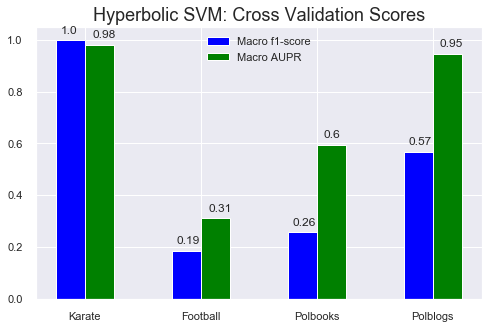

In [62]:
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [np.mean(karate_f1), np.mean(football_f1), np.mean(polbooks_f1), np.mean(polblogs_f1)]
bars2 = [karate_aupr, football_aupr, polbooks_aupr, polblogs_aupr]
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(8,5))
plt.style.use('seaborn')
sns.set(style="darkgrid")
plt.bar(r1, bars1, color='blue', width=barWidth, edgecolor='white', label='Macro f1-score')
plt.bar(r2, bars2, color='green', width=barWidth, edgecolor='white', label='Macro AUPR')
 
# Add xticks on the middle of the group bars
plt.xticks([r + barWidth/2 for r in range(len(bars1))], ['Karate', 'Football', 'Polbooks', 'Polblogs'])
 
plt.title('Hyperbolic SVM: Cross Validation Scores', size=18)

# add values onto barplot display
for i, score in enumerate(bars1):
    plt.text(i - barWidth/3, score+0.025, str(np.round(np.mean(score), 2)))
    
for i, score in enumerate(bars2):
    plt.text(i + 3*barWidth/4, score+0.025, str(np.round(np.mean(score), 2)))
    
# Create legend & Show graphic
plt.legend()
plt.show();

## References

**[1]**. "Large-margin classification in hyperbolic space" . Cho, H., Demeo, B., Peng, J., Berger, B. CoRR abs/1806.00437 (2018)<br>
**[2]**. https://github.com/plumdeq/hsvm <br>